In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial import distance
import multiprocessing as mp
from collections import defaultdict, deque
import random
import pandas as pd
from tqdm import tqdm
import urllib.request
import pathlib
import tsplib95
import numpy as np
import tsplib95, numpy as np
from math import sqrt
import pandas as pd, time, random
import pandas as pd, time, random, numpy as np
import os
import time
import urllib.request
import tsplib95
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

Parámetros sugeridos: {'num_particles': 50, 'max_iterations': 200, 'eta0': 0.045, 'sigma': 0.35, 'coupling_factor': 0.7, 'shape_param': 2.2}
Inicializando partículas...
Energía inicial mejor: 244274.83
Energía inicial promedio: 5176614.58

Evolucionando el sistema...
  Iteración 20/200: Mejor energía = 244274.83, Energía mínima actual = 245076.65, Energía promedio = 5180264.36
  Iteración 40/200: Mejor energía = 244274.83, Energía mínima actual = 247854.13, Energía promedio = 5193633.15
  Iteración 60/200: Mejor energía = 244274.83, Energía mínima actual = 247825.22, Energía promedio = 5229090.04
  Iteración 80/200: Mejor energía = 244274.83, Energía mínima actual = 289448.78, Energía promedio = 5260705.12
  Iteración 100/200: Mejor energía = 244274.83, Energía mínima actual = 350040.03, Energía promedio = 5302455.09
  Iteración 120/200: Mejor energía = 244274.83, Energía mínima actual = 423125.75, Energía promedio = 5322307.54
  Iteración 140/200: Mejor energía = 244274.83, Energía mí

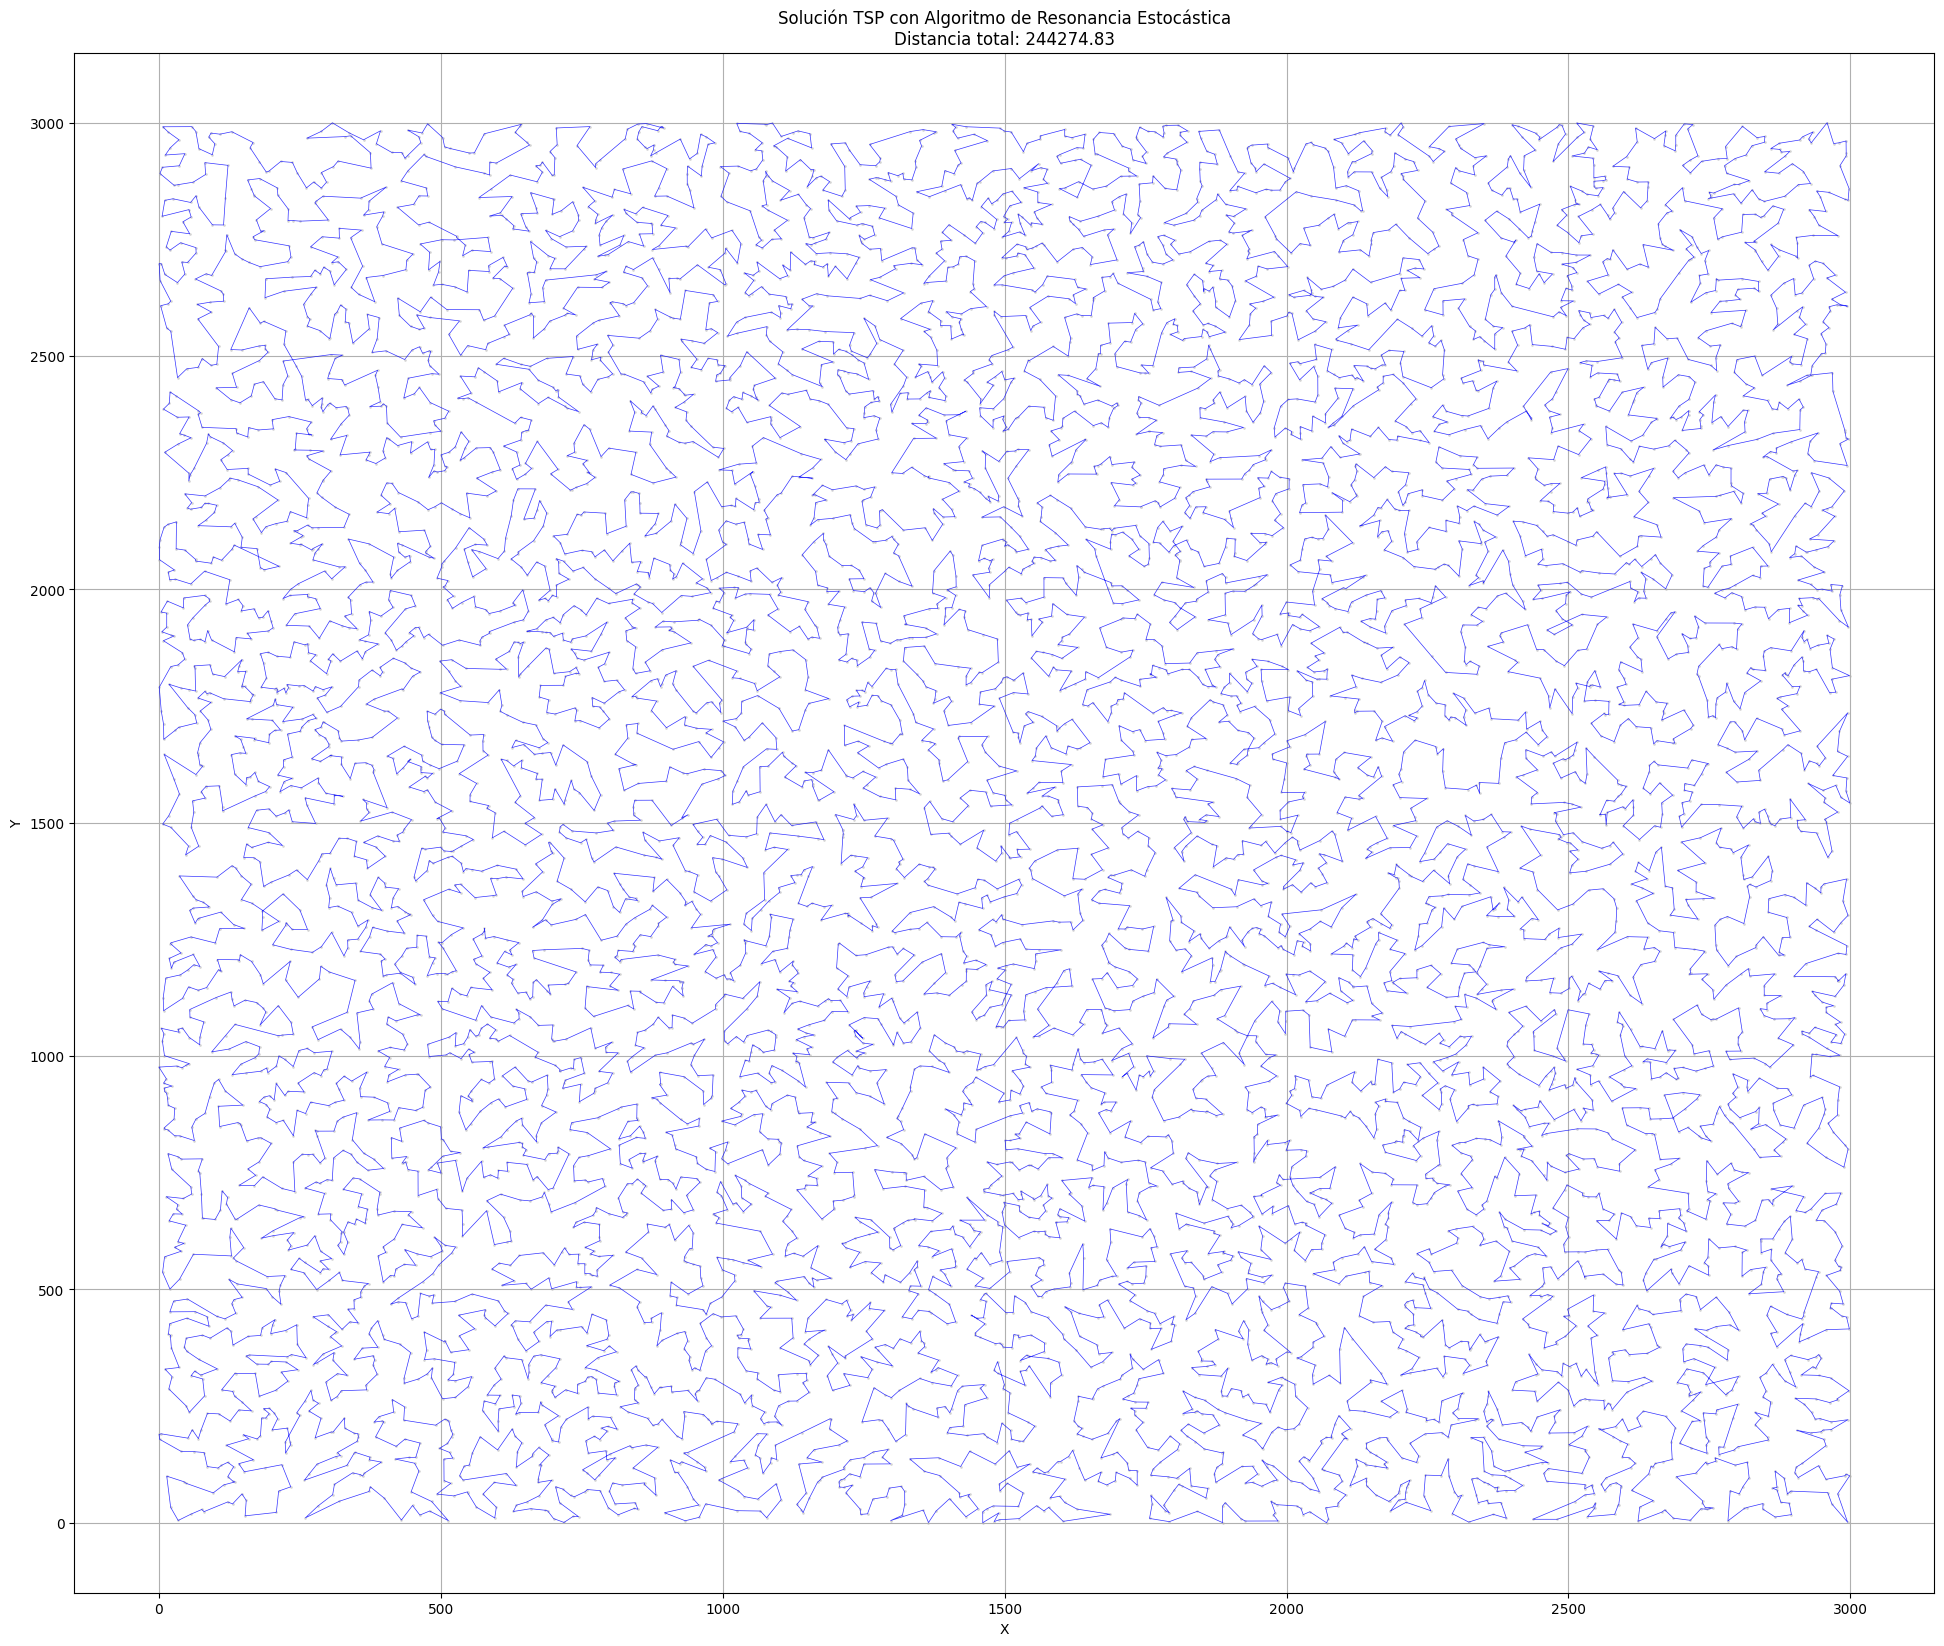

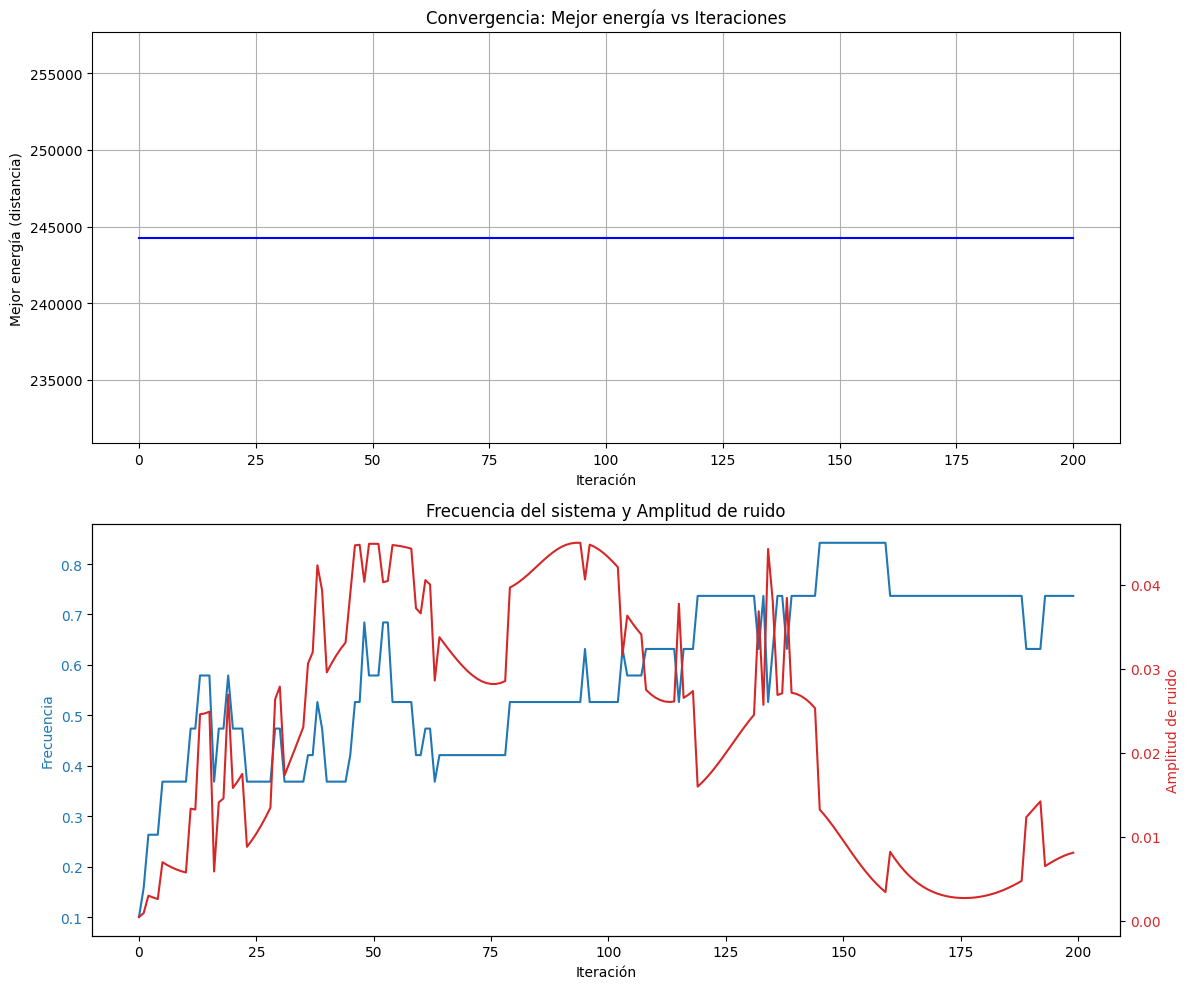

In [ ]:
class SRA_TSP:
    """
    Algoritmo de Resonancia Estocástica (SRA) para resolver el Problema del Viajante
    utilizando principios de sistemas dinámicos no lineales y resonancia estocástica.
    """

    def __init__(self, num_cities=1000, seed=None, num_particles=50,
                 eta0=0.1, sigma=0.5, coupling_factor=0.3, max_iterations=1000,
                 config=None, shape_param=2.0):
        """
        Inicializa el problema TSP para resolverlo con SRA

        Args:
            num_cities: Número de ciudades
            seed: Semilla para reproducibilidad
            num_particles: Número de partículas (tours candidatos)
            eta0: Amplitud base del ruido
            sigma: Ancho de banda de resonancia
            coupling_factor: Factor de acoplamiento entre partículas
            max_iterations: Número máximo de iteraciones
            config: Diccionario con configuración adicional
            shape_param: Parámetro α que controla la forma de la curva de resonancia
        """
        self.num_cities = num_cities
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        # Parámetros del algoritmo básicos
        self.num_particles = num_particles
        self.eta0 = eta0
        self.sigma = sigma
        self.coupling_factor = coupling_factor
        self.max_iterations = max_iterations
        self.shape_param = shape_param

        # Parámetros adicionales, valores por defecto si no se proporcionan
        self.config = config or {}
        self.area_size = self.config.get('area_size', 500)
        self.point_size = self.config.get('point_size', 2)
        self.segment_divisor = self.config.get('segment_divisor', 10)
        self.swap_factor = self.config.get('swap_factor', 0.1)
        self.opt2_iterations = self.config.get('2opt_iterations', 1000)

        # Generar coordenadas aleatorias para las ciudades en un plano 2D
        self.cities = np.random.rand(num_cities, 2) * self.area_size

        # Calcular la matriz de distancias entre todas las ciudades
        self.distance_matrix = self._calculate_distance_matrix()

        # Historial para análisis
        self.energy_history = []
        self.noise_history = []
        self.frequency_history = []
        self.best_energy_history = []

        # Mejor solución
        self.best_solution = None
        self.best_energy = float('inf')

    def _calculate_distance_matrix(self):
        """
        Calcula la matriz de distancias entre todas las ciudades

        Returns:
            Matriz de distancias
        """
        return distance.squareform(distance.pdist(self.cities, 'euclidean'))

    def get_route_distance(self, route):
        """
        Calcula la distancia total de una ruta

        Args:
            route: Lista de índices de ciudades representando una ruta

        Returns:
            Distancia total de la ruta
        """
        if not route or len(route) < 2:
          return float('inf')

        total_distance = 0
        for i in range(len(route)):
            j = (i + 1) % len(route)
            total_distance += self.distance_matrix[route[i], route[j]]

        return total_distance

    def _initialize_particles(self):
        """
        Inicializa el conjunto de partículas (tours candidatos)

        Returns:
            Lista de partículas (cada partícula es una lista de índices de ciudades)
        """
        particles = []

        # Generar partículas con diferentes estrategias de inicialización

        # 1. Algunos tours completamente aleatorios
        num_random = self.num_particles // 3
        for _ in range(num_random):
            tour = list(range(self.num_cities))
            random.shuffle(tour)
            particles.append(tour)

        # 2. Tours generados con heurística del vecino más cercano desde diferentes puntos
        num_greedy = self.num_particles // 3
        for _ in range(num_greedy):
            start_city = random.randint(0, self.num_cities - 1)
            tour = self._nearest_neighbor_tour(start_city)
            particles.append(tour)

        # 3. Tours generados con inserción aleatoria
        remaining = self.num_particles - len(particles)
        for _ in range(remaining):
            tour = self._random_insertion_tour()
            particles.append(tour)

        return particles

    def _nearest_neighbor_tour(self, start_city):
        """
        Genera un tour usando la heurística del vecino más cercano

        Args:
            start_city: Ciudad de inicio

        Returns:
            Tour completo
        """
        unvisited = set(range(self.num_cities))
        tour = [start_city]
        unvisited.remove(start_city)

        while unvisited:
            current = tour[-1]
            nearest = min(unvisited, key=lambda city: self.distance_matrix[current, city])
            tour.append(nearest)
            unvisited.remove(nearest)

        return tour

    def _random_insertion_tour(self):
        """
        Genera un tour usando inserción aleatoria

        Returns:
            Tour completo
        """
        # Comenzar con un tour pequeño
        cities = list(range(self.num_cities))
        random.shuffle(cities)
        tour = cities[:3]  
        remaining = cities[3:]

        # Ir insertando ciudades en la mejor posición
        for city in remaining:
            best_pos = 0
            best_increase = float('inf')

            # Probar insertar en cada posición posible
            for i in range(len(tour)):
                prev = tour[i]
                nxt = tour[(i + 1) % len(tour)]

                # Calcular incremento en la distancia
                increase = (
                    self.distance_matrix[prev, city] +
                    self.distance_matrix[city, nxt] -
                    self.distance_matrix[prev, nxt]
                )

                if increase < best_increase:
                    best_increase = increase
                    best_pos = i + 1

            # Insertar en la mejor posición
            tour.insert(best_pos % len(tour), city)

        return tour

    def _calculate_energy(self, tour):
        """
        Calcula la energía (distancia) de un tour

        Args:
            tour: Lista de índices de ciudades

        Returns:
            Energía (distancia) del tour
        """
        return self.get_route_distance(tour)

    def _calculate_gradient(self, tour, energy):
        """
        Calcula un "gradiente aproximado" para guiar la optimización

        Args:
            tour: Tour actual
            energy: Energía actual

        Returns:
            Gradiente (cambios sugeridos al tour actual)
        """
        # En lugar de un gradiente real, devolvemos un tour mejorado
        # basado en operaciones de 2-opt locales

        improved_tour = tour.copy()
        improved = False

        # Intentar algunas operaciones 2-opt aleatorias
        for _ in range(min(100, self.num_cities)):
            # Seleccionar dos posiciones aleatorias
            i = random.randint(0, self.num_cities - 2)
            j = random.randint(i + 1, self.num_cities - 1)

            # Evitar invertir todo el tour
            if i == 0 and j == self.num_cities - 1:
                continue

            # Calcular cambio en energía si invertimos el segmento [i+1, j]
            old_energy = (
                self.distance_matrix[tour[i], tour[i+1]] +
                self.distance_matrix[tour[j], tour[(j+1) % self.num_cities]]
            )
            new_energy = (
                self.distance_matrix[tour[i], tour[j]] +
                self.distance_matrix[tour[i+1], tour[(j+1) % self.num_cities]]
            )

            # Si mejora, aplicar el cambio
            if new_energy < old_energy:
                improved_tour[i+1:j+1] = improved_tour[i+1:j+1][::-1]
                improved = True
                break

        # Si no encontramos mejora, devolver el mismo tour
        if not improved:
            return tour, energy

        # Calcular nueva energía
        new_energy = self._calculate_energy(improved_tour)
        return improved_tour, new_energy

    def _calculate_coupling(self, particles, energies, particle_idx):
        """
        Calcula el efecto de acoplamiento entre partículas

        Args:
            particles: Lista de todas las partículas
            energies: Lista de energías correspondientes
            particle_idx: Índice de la partícula actual

        Returns:
            Tour modificado por efecto de acoplamiento
        """
        current_tour = particles[particle_idx]

        # Seleccionar partículas con mejor energía para acoplarse
        better_particles = []
        for i, (particle, energy) in enumerate(zip(particles, energies)):
            if i != particle_idx and energy < energies[particle_idx]:
                better_particles.append((particle, energy))

        # Si no hay mejores partículas, no hay acoplamiento
        if not better_particles:
            return current_tour

        # Ordenar por energía y tomar las mejores
        better_particles.sort(key=lambda x: x[1])
        best_particles = better_particles[:max(1, len(better_particles) // 3)]

        # Elegir una partícula aleatoria de las mejores
        influencer, _ = random.choice(best_particles)

        # Aplicar efecto de acoplamiento: tomar segmentos de la partícula influyente
        coupled_tour = current_tour.copy()

        # Determinar un segmento aleatorio para copiar
        max_seg = max(3, self.num_cities // self.segment_divisor)
        seg_length = random.randint(3, max_seg)
        start_pos = random.randint(0, self.num_cities - seg_length)

        # Segmento a copiar
        segment = influencer[start_pos:start_pos + seg_length]

        # Eliminar las ciudades del segmento del tour actual
        for city in segment:
            if city in coupled_tour:
                coupled_tour.remove(city)

        # Insertar el segmento en una posición aleatoria
        insert_pos = random.randint(0, len(coupled_tour))
        coupled_tour = coupled_tour[:insert_pos] + segment + coupled_tour[insert_pos:]

        return coupled_tour

    def _apply_noise(self, tour, eta):
        """
        Aplica ruido estocástico al tour

        Args:
            tour: Tour actual
            eta: Amplitud del ruido

        Returns:
            Tour perturbado
        """
        noisy_tour = tour.copy()

        # Determinar número de perturbaciones basado en eta
        num_swaps = max(1, int(eta * self.num_cities * self.swap_factor))

        # Aplicar intercambios aleatorios
        for _ in range(num_swaps):
            i, j = random.sample(range(self.num_cities), 2)
            noisy_tour[i], noisy_tour[j] = noisy_tour[j], noisy_tour[i]

        return noisy_tour

    def _estimate_frequency(self, energy_history, window=20):
        """
        Estima la frecuencia de oscilación actual basada en el historial de energía

        Args:
            energy_history: Historial de energías
            window: Tamaño de ventana para el análisis

        Returns:
            Frecuencia estimada
        """
        if len(energy_history) < window:
            return 0.5  # Frecuencia predeterminada

        # Tomar últimos valores
        recent = energy_history[-window:]

        # Contar los cruces por cero (aproximación de frecuencia)
        mean = sum(recent) / len(recent)
        crossings = 0
        for i in range(1, len(recent)):
            if (recent[i-1] - mean) * (recent[i] - mean) < 0:
                crossings += 1

        # Normalizar a [0,1]
        frequency = min(1.0, max(0.1, crossings / (window - 1)))
        return frequency

    def _estimate_resonance_frequency(self, iteration, max_iterations):
        """
        Estima la frecuencia de resonancia óptima

        Args:
            iteration: Iteración actual
            max_iterations: Número máximo de iteraciones

        Returns:
            Frecuencia de resonancia estimada
        """
        # La frecuencia de resonancia cambia con el tiempo
        # Comenzamos con alta frecuencia (exploración) y terminamos con baja (explotación)
        progress = iteration / max_iterations

        # Oscilación controlada para evitar estancamiento
        base_freq = 0.8 - 0.6 * progress
        oscillation = 0.1 * np.sin(iteration * 0.1)

        return base_freq + oscillation

    def _calculate_noise_amplitude(self, current_freq, resonance_freq):
        """
        Calcula la amplitud del ruido según la resonancia estocástica

        Args:
            current_freq: Frecuencia actual del sistema
            resonance_freq: Frecuencia de resonancia estimada

        Returns:
            Amplitud del ruido
        """
        # eta(t) = eta0 * exp( - (|f(t) - f_r(t)| / sigma)^alpha )
        diff = abs(current_freq - resonance_freq)
        exponent = - ((diff / self.sigma) ** self.shape_param)
        amplitude = self.eta0 * np.exp(exponent)

        return amplitude

    def _evolution_step(self, particles, energies, iteration):
        """
        Realiza un paso de evolución completo para todas las partículas

        Args:
            particles: Lista de partículas (tours)
            energies: Lista de energías correspondientes
            iteration: Iteración actual

        Returns:
            Nuevas partículas, nuevas energías
        """
        # Calcular frecuencia actual del sistema
        particle_history = self.energy_history[-self.num_particles:] if len(self.energy_history) >= self.num_particles else self.energy_history
        current_freq = self._estimate_frequency(particle_history)

        # Estimar frecuencia de resonancia
        resonance_freq = self._estimate_resonance_frequency(iteration, self.max_iterations)

        # Calcular amplitud del ruido 
        eta = self._calculate_noise_amplitude(current_freq, resonance_freq)

        # Registrar para análisis
        self.frequency_history.append(current_freq)
        self.noise_history.append(eta)

        # Evolucionar cada partícula
        new_particles = []
        new_energies = []

        for i, (particle, energy) in enumerate(zip(particles, energies)):
            # 1. Calcular gradiente
            gradient_particle, gradient_energy = self._calculate_gradient(particle, energy)

            # 2. Aplicar acoplamiento si el gradiente no mejoró
            if gradient_energy >= energy:
                coupled_particle = self._calculate_coupling(particles, energies, i)
                coupled_energy = self._calculate_energy(coupled_particle)

                # Usar el resultado del acoplamiento si es mejor que el original
                if coupled_energy < energy:
                    gradient_particle = coupled_particle
                    gradient_energy = coupled_energy

            # 3. Aplicar ruido estocástico
            noisy_particle = self._apply_noise(gradient_particle, eta)
            noisy_energy = self._calculate_energy(noisy_particle)

            # 4. Elegir entre la partícula original, la del gradiente y la ruidosa
            candidates = [(particle, energy),
                          (gradient_particle, gradient_energy),
                          (noisy_particle, noisy_energy)]
            candidates.sort(key=lambda x: x[1])  # Ordenar por energía

            # Selección probabilística favoreciendo mejores soluciones
            probabilities = [0.6, 0.3, 0.1]  
            choice = random.choices([0, 1, 2], weights=probabilities, k=1)[0]
            selected_particle, selected_energy = candidates[choice]

            new_particles.append(selected_particle)
            new_energies.append(selected_energy)

            # Actualizar mejor solución global
            if selected_energy < self.best_energy:
                self.best_solution = selected_particle.copy()
                self.best_energy = selected_energy

            # Registrar para análisis
            self.energy_history.append(selected_energy)

        return new_particles, new_energies

    def solve(self, verbose=True):
        """
        Aplica el Algoritmo de Resonancia Estocástica para resolver el TSP

        Args:
            verbose: Si es True, muestra información durante la ejecución

        Returns:
            Mejor ruta encontrada, distancia, tiempo de ejecución
        """
        start_time = time.time()

        # Inicializar partículas
        if verbose:
            print("Inicializando partículas...")

        particles = self._initialize_particles()
        energies = [self._calculate_energy(p) for p in particles]

        # Encontrar mejor solución inicial
        best_idx = np.argmin(energies)
        self.best_solution = particles[best_idx].copy()
        self.best_energy = energies[best_idx]

        if verbose:
            print(f"Energía inicial mejor: {self.best_energy:.2f}")
            print(f"Energía inicial promedio: {sum(energies)/len(energies):.2f}")

        # Registrar para análisis
        self.energy_history.extend(energies)
        self.best_energy_history.append(self.best_energy)

        # Evolución del sistema
        if verbose:
            print("\nEvolucionando el sistema...")

        for iteration in range(self.max_iterations):
            # Realizar un paso de evolución
            particles, energies = self._evolution_step(particles, energies, iteration)

            # Registrar mejor energía
            self.best_energy_history.append(self.best_energy)

            # Mostrar progreso
            if verbose and (iteration + 1) % (self.max_iterations // 10) == 0:
                avg_energy = sum(energies) / len(energies)
                min_energy = min(energies)
                print(f"  Iteración {iteration + 1}/{self.max_iterations}: "
                      f"Mejor energía = {self.best_energy:.2f}, "
                      f"Energía mínima actual = {min_energy:.2f}, "
                      f"Energía promedio = {avg_energy:.2f}")

        execution_time = time.time() - start_time

        if verbose:
            print("\nResultados:")
            print(f"  Distancia final: {self.best_energy:.2f}")
            print(f"  Tiempo de ejecución: {execution_time:.2f} segundos")

        return self.best_solution, self.best_energy, execution_time

    def compare_with_nearest_neighbor(self):
        """
        Compara con el algoritmo del vecino más cercano

        Returns:
            Ruta del vecino más cercano, distancia
        """
        best_route = None
        best_distance = float('inf')

        # Limitamos a probar desde 5 ciudades de inicio para problemas grandes
        for start_city in range(min(self.num_cities, 5)):
            route = self._nearest_neighbor_tour(start_city)
            distance = self.get_route_distance(route)
            if distance < best_distance:
                best_distance = distance
                best_route = route

        # Mejorar con 2-opt limitado para problemas grandes
        improved_route = self._improve_with_2opt(best_route)
        improved_distance = self.get_route_distance(improved_route)

        return improved_route, improved_distance

    def _improve_with_2opt(self, route, max_iterations=100):
        """
        Mejora una ruta utilizando el algoritmo 2-opt con límite de iteraciones

        Args:
            route: Ruta inicial
            max_iterations: Número máximo de iteraciones

        Returns:
            Ruta mejorada
        """
        if max_iterations is None:
            max_iterations = self.opt2_iterations

        actual_iterations = min(max_iterations, self.num_cities * 10)
        best_route = route.copy()
        improved = True
        iterations = 0

        while improved and iterations < actual_iterations:
            improved = False
            iterations += 1

            # Intentar algunas mejoras aleatorias en lugar de exploración exhaustiva
            for _ in range(min(100, self.num_cities)):
                i = random.randint(0, self.num_cities - 2)
                j = random.randint(i + 1, self.num_cities - 1)

                if i == 0 and j == self.num_cities - 1:
                    continue

                old_distance = (
                    self.distance_matrix[route[i], route[i+1]] +
                    self.distance_matrix[route[j], route[(j+1) % self.num_cities]]
                )
                new_distance = (
                    self.distance_matrix[route[i], route[j]] +
                    self.distance_matrix[route[i+1], route[(j+1) % self.num_cities]]
                )

                if new_distance < old_distance:
                    best_route[i+1:j+1] = best_route[i+1:j+1][::-1]
                    improved = True
                    break

        return best_route

    def plot_solution(self, route=None, title="Solución TSP con Algoritmo de Resonancia Estocástica"):
        """
        Visualiza una solución en un gráfico

        Args:
            route: Ruta a visualizar (si es None, usa self.best_solution)
            title: Título del gráfico
        """
        if route is None:
            if self.best_solution is None:
                print("Primero debe ejecutar el método solve()")
                return
            route = self.best_solution

        plt.figure(figsize=(24, 20))

        route_coords = np.array([self.cities[i] for i in route])
        route_coords = np.vstack([route_coords, route_coords[0]])  # Cerrar ciclo

        plt.scatter(self.cities[:, 0], self.cities[:, 1], c='lightgray', s=self.point_size, zorder=1)
        plt.plot(route_coords[:, 0], route_coords[:, 1], 'b-', alpha=0.8, linewidth=0.5, zorder=2)
        distance = self.get_route_distance(route)
        plt.title(f"{title}\nDistancia total: {distance:.2f}")
        plt.grid(True)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    def plot_convergence(self):
        """
        Visualiza la convergencia del algoritmo
        """
        if not self.best_energy_history:
            print("Primero debe ejecutar el método solve()")
            return

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # 1. Gráfico de convergencia (mejor energía vs iteraciones)
        iterations = range(len(self.best_energy_history))
        ax1.plot(iterations, self.best_energy_history, 'b-')
        ax1.set_title("Convergencia: Mejor energía vs Iteraciones")
        ax1.set_xlabel("Iteración")
        ax1.set_ylabel("Mejor energía (distancia)")
        ax1.grid(True)

        # 2. Gráfico de frecuencia y amplitud de ruido
        if self.frequency_history and self.noise_history:
            ax2.set_title("Frecuencia del sistema y Amplitud de ruido")
            ax2.set_xlabel("Iteración")

            color = 'tab:blue'
            ax2.set_ylabel('Frecuencia', color=color)
            ax2.plot(self.frequency_history, color=color)
            ax2.tick_params(axis='y', labelcolor=color)

            ax3 = ax2.twinx()
            color = 'tab:red'
            ax3.set_ylabel('Amplitud de ruido', color=color)
            ax3.plot(self.noise_history, color=color)
            ax3.tick_params(axis='y', labelcolor=color)

            fig.tight_layout()

        plt.show()
    
def autoconfig(num_cities):
    """
    Devuelve un dict de hiperparámetros SRA sugeridos
    según patrones empíricos encontrados.
    """
    # Escalado de partículas (≈√N) con clip
    num_particles = max(10, min(300, int(0.5*np.sqrt(num_cities))))
    
    # Iteraciones algo sub‑lineales
    max_iterations = max(30, int(8 * (num_cities ** 0.35)))
    
    # Ruido base decreciente con N
    eta0 = 0.045 * (num_cities / 10000) ** -0.25     
    
    # Banda sigma ligeramente decreciente
    sigma = 0.35 * (num_cities / 10000) ** -0.15
    
    # Acoplamiento sube suavemente 
    coupling_factor = min(0.7, 0.25 + 0.15*np.log10(num_cities))
    
    # Forma de resonancia: un poco más estrecha a gran escala
    shape_param = 1.8 + 0.4 * (num_cities / 10000)
    
    return {
        'num_particles': num_particles,
        'max_iterations': max_iterations,
        'eta0': round(eta0, 4),
        'sigma': round(sigma, 3),
        'coupling_factor': round(coupling_factor, 3),
        'shape_param': round(shape_param, 2)
    }

# ------------------ EJECUCION ------------------ #
if __name__ == "__main__":
    # Configuración principal
    num_cities = 10000
    seed = 42

    # Hiperparámetros generados
    auto_params = autoconfig(num_cities)

    # ver parametros seleccionados:
    print("Parámetros sugeridos:", auto_params)

    # Config. principal 
    problem_config = {
        'num_cities': num_cities,
        'seed': seed,
        **auto_params              
    }

    # Parámetros adicionales de visualización y comportamiento
    visualization_config = {
        'area_size': 3000,
        'point_size': 0.7,
        'segment_divisor': 35,
        'swap_factor': 0.018,
    }

    # Crear instancia del solver con la nueva ecuación de ruido
    tsp = SRA_TSP(**problem_config, config=visualization_config)

    # Inicializamos de nuevo las ciudades con el area_size deseado 
    tsp.cities = np.random.rand(problem_config['num_cities'], 2) * visualization_config['area_size']
    tsp.distance_matrix = tsp._calculate_distance_matrix()

    # Resolvemos el TSP
    best_route, best_distance, exec_time = tsp.solve()

    print("\nComparando con Vecino Más Cercano mejorado...")
    nn_route, nn_dist = tsp.compare_with_nearest_neighbor()
    improv = (nn_dist - best_distance) / nn_dist * 100
    print(f"Distancia NN mejorada: {nn_dist:.2f}")
    print(f"Distancia SRA: {best_distance:.2f}")
    print(f"Mejora (%): {improv:.2f}%")

    tsp.plot_solution()

    # Visualizamos convergencia 
    tsp.plot_convergence()

In [ ]:
# Configuración visual y fija
visualization_config = {
    'area_size': 3000,
    'point_size': 0.7,
    'segment_divisor': 35,
    'swap_factor': 0.018,
}

city_sizes = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
samples_per_size = 10
results = []

output_path = "random_search_sra_results.csv"

# Crear archivo vacío con columnas si aún no existe
df_init = pd.DataFrame(columns=[
    'num_cities', 'params', 'seed', 'shape_param',
    'best_distance', 'nn_distance', 'improvement_%', 'exec_time'
])
df_init.to_csv(output_path, index=False)

for num_cities in city_sizes:
    print(f"🔍 Buscando en {num_cities} ciudades...")

    for _ in tqdm(range(samples_per_size)):
        base_particles = 50
        base_cities = 10000
        alpha = 0.5

        scaled_particles = int(base_particles * (base_cities / num_cities) ** alpha)
        num_particles = max(5, min(300, scaled_particles + random.randint(-3, 3)))

        sample_seed = random.randint(0, 100)
        random.seed(sample_seed)
        np.random.seed(sample_seed)

        params = {
            'num_cities': num_cities,
            'seed': sample_seed,
            'num_particles': num_particles,
            'eta0': round(random.uniform(0.005, 0.05), 4),
            'sigma': round(random.uniform(0.05, 0.5), 3),
            'coupling_factor': round(random.uniform(0.1, 0.7), 3),
            'max_iterations': random.randint(30, 100),
        }
        shape_param = round(random.uniform(1.2, 3.0), 2)

        tsp = SRA_TSP(**params, config=visualization_config, shape_param=shape_param)
        tsp.cities = np.random.rand(num_cities, 2) * visualization_config['area_size']
        tsp.distance_matrix = tsp._calculate_distance_matrix()

        try:
            best_route, best_distance, exec_time = tsp.solve(verbose=False)
            nn_route, nn_dist = tsp.compare_with_nearest_neighbor()
            improvement = (nn_dist - best_distance) / nn_dist * 100

            row = {
                'num_cities': num_cities,
                'params': params,
                'seed': sample_seed,
                'shape_param': shape_param,
                'best_distance': best_distance,
                'nn_distance': nn_dist,
                'improvement_%': improvement,
                'exec_time': exec_time
            }

            # Agregar fila al archivo
            pd.DataFrame([row]).to_csv(output_path, mode='a', header=False, index=False)
            results.append(row)

        except Exception as e:
            print(f"⚠️ Error en configuración: {params} -> {e}")
            continue

print(f"✅ Resultados guardados progresivamente en {output_path}")


🔍 Buscando en 1000 ciudades...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [05:05<00:00, 30.53s/it]


🔍 Buscando en 2000 ciudades...


100%|██████████| 10/10 [09:04<00:00, 54.47s/it]


🔍 Buscando en 3000 ciudades...


100%|██████████| 10/10 [16:07<00:00, 96.70s/it]


🔍 Buscando en 4000 ciudades...


100%|██████████| 10/10 [23:11<00:00, 139.17s/it]


🔍 Buscando en 5000 ciudades...


100%|██████████| 10/10 [33:08<00:00, 198.81s/it]


🔍 Buscando en 6000 ciudades...


100%|██████████| 10/10 [43:11<00:00, 259.11s/it]


🔍 Buscando en 7000 ciudades...


100%|██████████| 10/10 [56:09<00:00, 336.92s/it]


🔍 Buscando en 8000 ciudades...


100%|██████████| 10/10 [1:07:46<00:00, 406.62s/it]


🔍 Buscando en 9000 ciudades...


 50%|█████     | 5/10 [44:14<47:11, 566.35s/it]  

## Prubas Libreria

In [ ]:
def get_tsplib_from_github(name):
    url = f"https://raw.githubusercontent.com/rhgrant10/tsplib95/master/archives/problems/tsp/{name}.tsp"
    tgt = pathlib.Path(f"{name}.tsp")
    if not tgt.exists():
        print("Descargando desde GitHub...")
        urllib.request.urlretrieve(url, tgt)
    return tgt

path = get_tsplib_from_github("berlin52")
problem = tsplib95.load(path)
coords = np.array([problem.node_coords[i+1] for i in range(problem.dimension)])

print("Número de ciudades:", len(coords))

Número de ciudades: 52


In [ ]:
tsp = SRA_TSP(num_cities=len(coords), seed=0,
              eta0=0.04, sigma=0.35, shape_param=2.2,
              num_particles=30, max_iterations=150,
              config={'area_size':1})          

tsp.cities = coords.astype(float)             
tsp.distance_matrix = tsp._calculate_distance_matrix()

best_route, best_dist, elapsed = tsp.solve(verbose=False)
print("mejor distancia:", best_dist, "| tiempo:", elapsed)

mejor distancia: 8229.000938479461 | tiempo: 0.48438215255737305


In [48]:
opt_dist = 7542
error_relativo = 100 * (best_dist - opt_dist) / opt_dist
print(f"Diferencia vs óptimo: {error_relativo:.2f}%")

Diferencia vs óptimo: 9.11%


In [ ]:
n = len(coords)
params = autoconfig(n)          

tsp = SRA_TSP(num_cities=n, seed=0, **params, config={'area_size':1})
tsp.cities = coords.astype(float)
tsp.distance_matrix = tsp._calculate_distance_matrix()
best_route, best_dist, elapsed = tsp.solve(verbose=False)
print("Distancia:", best_dist, "| t:", elapsed)

Distancia: 8257.185876232192 | t: 0.03373289108276367


In [ ]:
results = []
for seed in range(30):
    tsp = SRA_TSP(num_cities=len(coords), seed=seed,
                  eta0=0.04, sigma=0.35, shape_param=2.2,
                  num_particles=30, max_iterations=150,
                  config={'area_size':1})
    tsp.cities = coords.astype(float)
    tsp.distance_matrix = tsp._calculate_distance_matrix()
    _, dist, t = tsp.solve(verbose=False)
    results.append({"seed":seed, "distance":dist, "time":t})

df = pd.DataFrame(results)
print(df.distance.mean(), "±", df.distance.std())

7935.399307948418 ± 147.04006894303973


In [ ]:
results = []
n = len(coords)                  
base_params = autoconfig(n)      

for seed in range(30):
    # fija las RNGs para reproducibilidad
    np.random.seed(seed)
    random.seed(seed)

    tsp = SRA_TSP(num_cities=n, seed=seed, **base_params,
                  config={'area_size':1})
    tsp.cities = coords.astype(float)
    tsp.distance_matrix = tsp._calculate_distance_matrix()
    _, dist, t = tsp.solve(verbose=False)

    results.append({
        "seed": seed,
        "distance": dist,
        "time": t
    })

df = pd.DataFrame(results)
print(f"media = {df.distance.mean():.2f}  ±  {df.distance.std():.2f}")

media = 8133.78  ±  167.07


### Validacion Rendimiento

In [ ]:
def download_opt_tour(name):
    url = f"https://raw.githubusercontent.com/rhgrant10/tsplib95/master/archives/problems/tour/{name}.opt.tour"
    file_path = Path(f"datasets/{name}.opt.tour")
    if not file_path.exists():
        print(f"Descargando .opt.tour de {name}...")
        urllib.request.urlretrieve(url, file_path)
    return file_path

def get_optimal_distance(name):
    tsp_path = download_dataset(name)
    problem = tsplib95.load(tsp_path)
    
    # Descargar el .opt.tour
    opt_tour_path = download_opt_tour(name)
    
    # Lee el tour óptimo 
    with open(opt_tour_path, 'r') as f:
        lines = f.readlines()
    
    # Extrae nodos (ignora cabecera y EOF)
    tour = []
    reading = False
    for line in lines:
        line = line.strip()
        if line == "TOUR_SECTION":
            reading = True
            continue
        if line == "-1" or line == "EOF":
            break
        if reading:
            tour.append(int(line))
    
    # Calcular distancia total del tour 
    total_dist = 0
    for i in range(len(tour)):
        j = (i + 1) % len(tour)
        total_dist += problem.get_weight(tour[i], tour[j])
    
    return total_dist


In [ ]:
opt_distance = get_optimal_distance("berlin52")
print("Óptimo real:", opt_distance)

Óptimo real: 7542


Division de probelmas del dataset

In [ ]:
def build_full_datasets():
    datasets_auto = {
        "basic": {
            "berlin52": None,
            "eil76": None,
            "eil101": None
        },
        "intermediate": {
            "pcb442": None
        },
        "advanced": {
            "pr1002": None
        }
    }

    datasets_manual = {
        "intermediate": {
            "lin318": 42029,
            "pr439": 107217
        },
        "advanced": {
            "rat783": 8806
        },
        "extreme": {
            "rl1323": 270199,
            "d1655": 62128,
            "d2103": 80450,
            "pcb3038": 137694
        }
    }

    datasets = {}

    for level, problems in datasets_auto.items():
        datasets[level] = {}
        for name in problems:
            try:
                opt = get_optimal_distance(name)
                datasets[level][name] = round(opt)
                print(f"✅ {name}: óptimo = {opt}")
            except Exception as e:
                print(f"⚠️ {name}: error = {e}")
                datasets[level][name] = None

    for level, problems in datasets_manual.items():
        if level not in datasets:
            datasets[level] = {}
        for name, opt in problems.items():
            datasets[level][name] = opt

    return datasets

datasets = build_full_datasets()


✅ berlin52: óptimo = 7542
✅ eil76: óptimo = 538
✅ eil101: óptimo = 629
✅ pcb442: óptimo = 50778
⚠️ pr1002: error = invalid literal for int() with base 10: '1    2    5    3    4    6    7    8    9   10   11   12   63   64   62   61'


In [ ]:
def download_dataset(name):
    url = f"https://raw.githubusercontent.com/rhgrant10/tsplib95/master/archives/problems/tsp/{name}.tsp"
    file_path = Path(f"datasets/{name}.tsp")
    file_path.parent.mkdir(parents=True, exist_ok=True)
    if not file_path.exists():
        print(f"Descargando {name}...")
        urllib.request.urlretrieve(url, file_path)
    return file_path

def run_single(name, opt=None, seed=42):
    tsp_path = download_dataset(name)
    problem = tsplib95.load(tsp_path)
    coords = np.array([problem.node_coords[i+1] for i in range(problem.dimension)])
    n = len(coords)
    params = autoconfig(n)
    tsp = SRA_TSP(num_cities=n, seed=seed, **params, config={'area_size':1})
    tsp.cities = coords.astype(float)
    tsp.distance_matrix = tsp._calculate_distance_matrix()
    best_route, best_dist, elapsed = tsp.solve(verbose=False)
    improvement = None if opt is None else 100 * (opt - best_dist) / opt
    return {
        "name": name, "n": n, "distance": best_dist, "time": elapsed,
        "relative_improvement_%": improvement
    }


def run_multiple(name, opt=None, reps=30):
    tsp_path = download_dataset(name)
    problem = tsplib95.load(tsp_path)
    coords = np.array([problem.node_coords[i+1] for i in range(problem.dimension)])
    n = len(coords)
    records = []
    for seed in range(reps):
        params = autoconfig(n)
        tsp = SRA_TSP(num_cities=n, seed=seed, **params, config={'area_size':1})
        tsp.cities = coords.astype(float)
        tsp.distance_matrix = tsp._calculate_distance_matrix()
        _, dist, t = tsp.solve(verbose=False)
        improvement = None if opt is None else 100 * (opt - dist) / opt
        records.append({
            "seed": seed,
            "distance": dist,
            "time": t,
            "relative_improvement_%": improvement
        })
    df = pd.DataFrame(records)
    display(df.describe())
    return df

def run_all_multiple(reps=30):
    results = {}
    for level, data in datasets.items():
        for name, opt in data.items():
            print(f"▶ Ejecutando {name} ({level})...")
            df = run_multiple(name, opt=opt, reps=reps)
            results[name] = df
    return results


def run_all_once():
    from IPython.display import display, Markdown

    results = []
    for level, data in datasets.items():
        display(Markdown(f"### 🔷 Nivel: `{level.upper()}`"))
        for name, opt in data.items():
            display(Markdown(f"**🔍 Ejecutando `{name}`...**"))
            r = run_single(name, opt=opt)
            r["level"] = level
            results.append(r)
            display(pd.DataFrame([r]))
    df = pd.DataFrame(results)
    display(Markdown("### ✅ Resultado Final"))
    display(df)
    return df


In [ ]:
all_dfs = run_all_multiple(reps=50)

▶ Ejecutando berlin52 (basic)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,8101.156700,0.022612,-7.413905
std,14.57738,187.861544,0.002310,2.490872
min,0.00000,7749.565017,0.017738,-12.460859
25%,12.25000,7953.388357,0.021186,-9.127418
50%,24.50000,8135.537980,0.022412,-7.869769
75%,36.75000,8230.389848,0.023551,-5.454632
max,49.00000,8481.798013,0.031585,-2.752122


▶ Ejecutando eil76 (basic)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,579.726290,0.039525,-7.755816
std,14.57738,5.701596,0.005017,1.059776
min,0.00000,561.934715,0.031180,-9.648529
25%,12.25000,575.670753,0.036543,-8.431481
50%,24.50000,580.891698,0.039082,-7.972435
75%,36.75000,583.361369,0.041466,-7.001999
max,49.00000,589.909088,0.058199,-4.448832


▶ Ejecutando eil101 (basic)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,685.393075,0.057057,-8.965513
std,14.57738,7.743184,0.007227,1.231031
min,0.00000,662.522928,0.047331,-11.509242
25%,12.25000,680.258952,0.052361,-9.762161
50%,24.50000,684.887820,0.055670,-8.885186
75%,36.75000,690.403993,0.058835,-8.149277
max,49.00000,701.393134,0.081318,-5.329559


▶ Ejecutando pcb442 (intermediate)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,57351.323964,0.633487,-12.945220
std,14.57738,564.146648,0.271564,1.111006
min,0.00000,55515.518423,0.433137,-15.327737
25%,12.25000,57110.042821,0.458074,-13.574961
50%,24.50000,57400.627928,0.473235,-13.042317
75%,36.75000,57671.093445,1.017776,-12.470052
max,49.00000,58561.118242,1.131814,-9.329864


▶ Ejecutando lin318 (intermediate)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,45846.723311,0.609756,-9.083545
std,14.57738,444.358230,0.033369,1.057266
min,0.00000,44924.091238,0.531873,-11.449501
25%,12.25000,45527.432962,0.588110,-9.733961
50%,24.50000,45806.987343,0.609015,-8.989001
75%,36.75000,46120.086485,0.626247,-8.323855
max,49.00000,46841.110567,0.714627,-6.888318


▶ Ejecutando pr439 (intermediate)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,119589.295250,0.879740,-11.539490
std,14.57738,1382.149788,0.276733,1.289114
min,0.00000,117094.914190,0.442922,-14.043946
25%,12.25000,118675.001088,0.497203,-12.358789
50%,24.50000,119677.913924,1.021263,-11.622144
75%,36.75000,120467.722886,1.081982,-10.686739
max,49.00000,122274.498075,1.283774,-9.213011


▶ Ejecutando pr1002 (advanced)...


,seed,distance,time
count,50.00000,50.000000,50.000000
mean,24.50000,288336.438250,5.895841
std,14.57738,1503.946248,0.857873
min,0.00000,285034.533159,2.859334
25%,12.25000,287433.783091,5.748363
50%,24.50000,288568.470853,5.826416
75%,36.75000,289491.925327,6.403096
max,49.00000,291237.128705,7.090017


▶ Ejecutando rat783 (advanced)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,9905.673428,4.051539,-12.487775
std,14.57738,52.768152,0.096261,0.599230
min,0.00000,9788.731436,3.879910,-13.716304
25%,12.25000,9871.729474,3.996167,-12.963812
50%,24.50000,9916.675199,4.040224,-12.612710
75%,36.75000,9947.593304,4.084410,-12.102311
max,49.00000,10013.857745,4.365748,-11.159794


▶ Ejecutando rl1323 (extreme)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,316646.024229,9.797400,-17.189932
std,14.57738,2705.326090,1.931478,1.001235
min,0.00000,309683.468321,7.648808,-19.097572
25%,12.25000,315192.606173,8.837925,-17.757392
50%,24.50000,316700.137352,9.024448,-17.209959
75%,36.75000,318179.296339,9.634158,-16.652025
max,49.00000,321800.448612,15.507092,-14.613107


▶ Ejecutando d1655 (extreme)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,72322.967752,18.418474,-16.409618
std,14.57738,372.051118,3.618875,0.598846
min,0.00000,71448.229959,14.715313,-17.538511
25%,12.25000,72099.732301,16.820787,-16.841277
50%,24.50000,72349.070065,17.433455,-16.451632
75%,36.75000,72591.148821,18.445451,-16.050303
max,49.00000,73024.325817,28.489715,-15.001658


▶ Ejecutando d2103 (extreme)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,89367.650674,46.071893,-11.084712
std,14.57738,1041.667332,1.112924,1.294801
min,0.00000,87527.940561,44.090997,-13.590378
25%,12.25000,88400.109684,45.280513,-12.090067
50%,24.50000,89689.903377,45.876427,-11.485275
75%,36.75000,90176.458552,46.844600,-9.882051
max,49.00000,91383.458894,48.257061,-8.797937


▶ Ejecutando pcb3038 (extreme)...


,seed,distance,time,relative_improvement_%
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,158315.034164,92.823713,-14.975986
std,14.57738,454.548080,23.649106,0.330115
min,0.00000,157247.748650,46.242045,-15.589679
25%,12.25000,158035.368811,69.885312,-15.237966
50%,24.50000,158312.077643,103.743122,-14.973839
75%,36.75000,158675.764754,111.134612,-14.772880
max,49.00000,159160.052340,116.331867,-14.200872


In [ ]:
def plot_results(all_dfs):
    for name, df in all_dfs.items():
        plt.figure(figsize=(12, 5))

        # --- Boxplot de distancia ---
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df['distance'])
        plt.title(f"{name}: Distribución de distancias")
        plt.ylabel("Distancia")

        # --- Histograma de mejora relativa ---
        plt.subplot(1, 2, 2)
        if 'relative_improvement_%' in df:
            sns.histplot(df['relative_improvement_%'], kde=True)
            plt.axvline(x=0, color='red', linestyle='--', label='Óptimo')
            plt.title(f"{name}: Mejora relativa vs óptimo (%)")
            plt.xlabel("Mejora (%)")
            plt.legend()

        plt.tight_layout()
        plt.show()


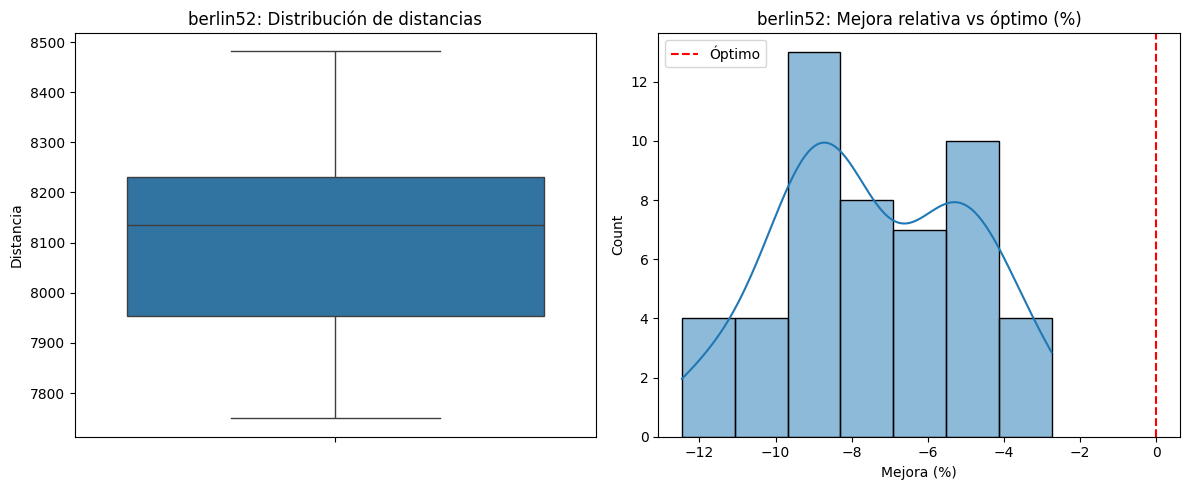

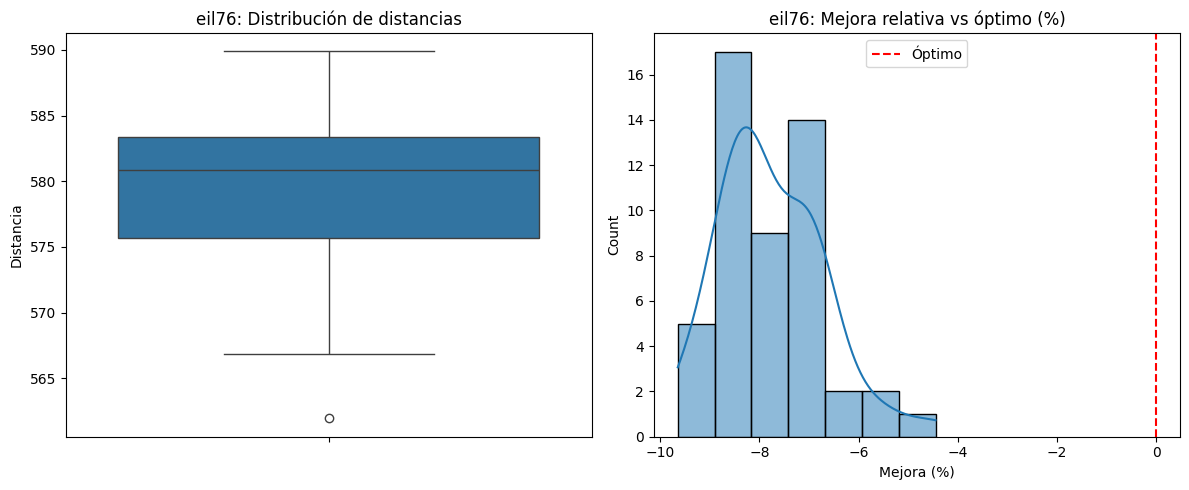

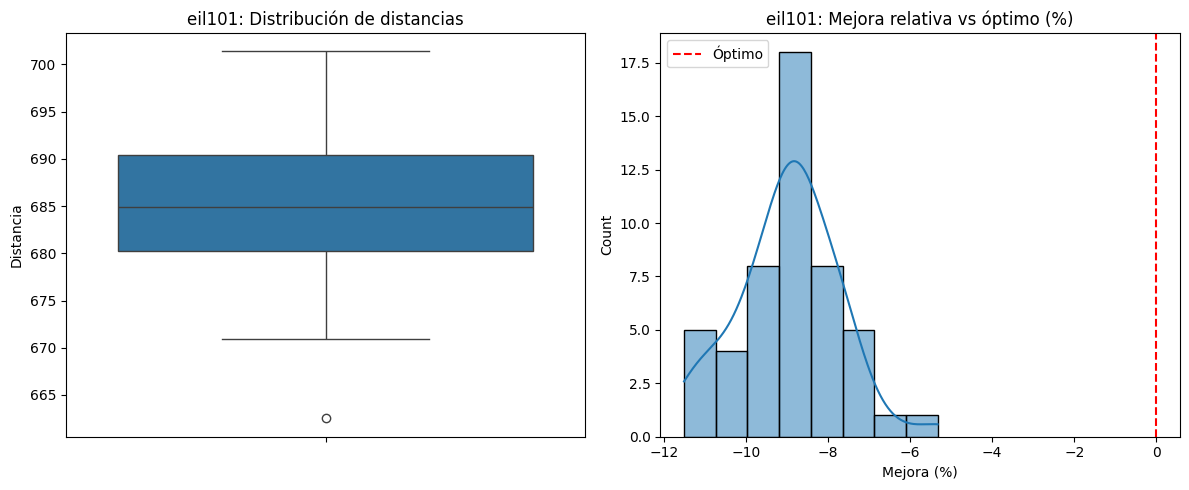

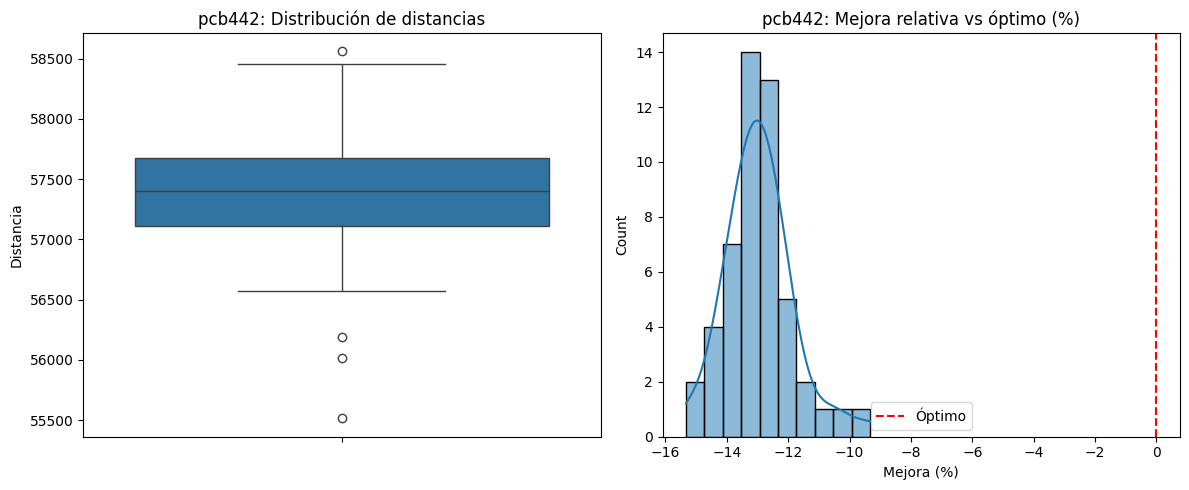

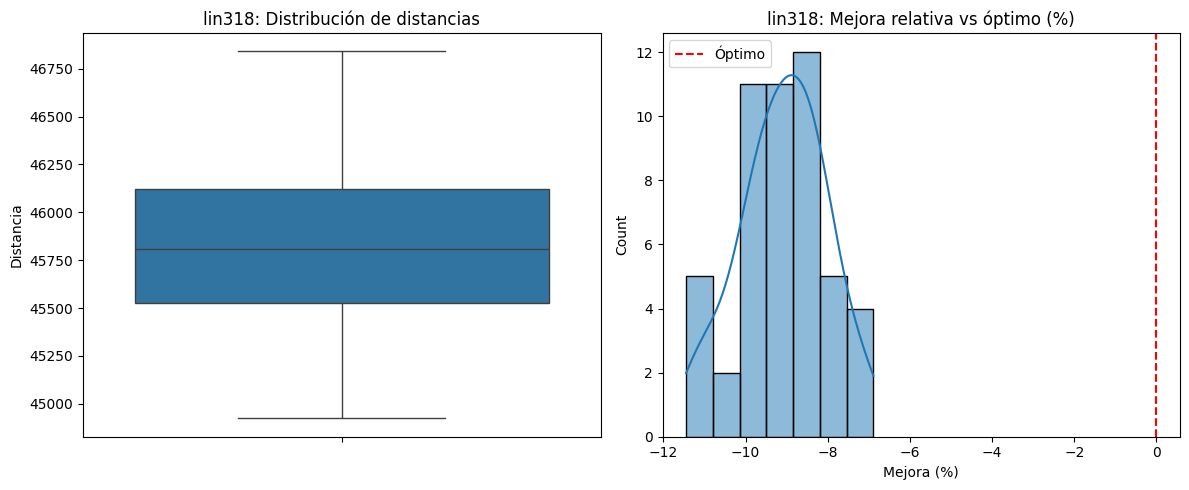

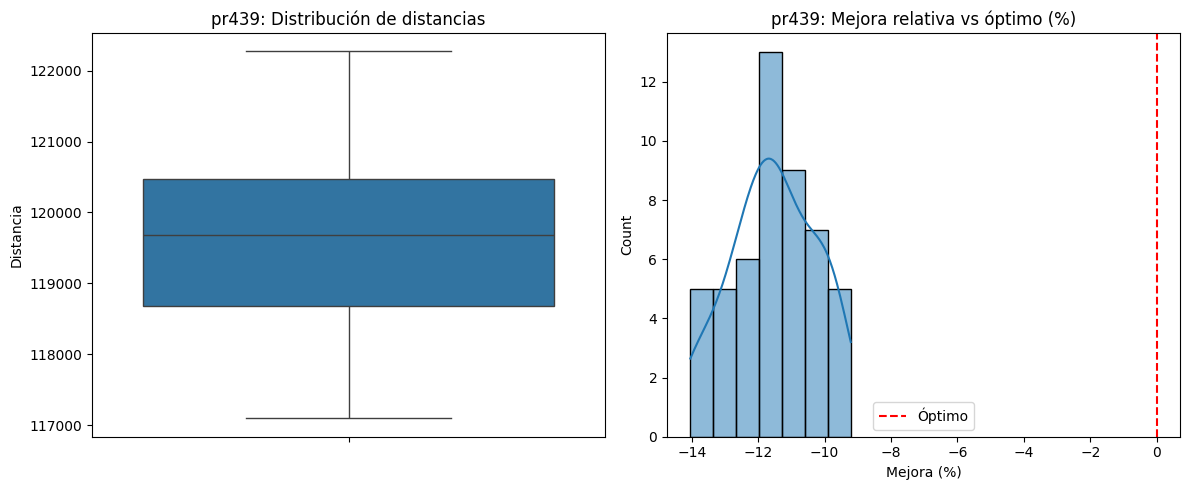

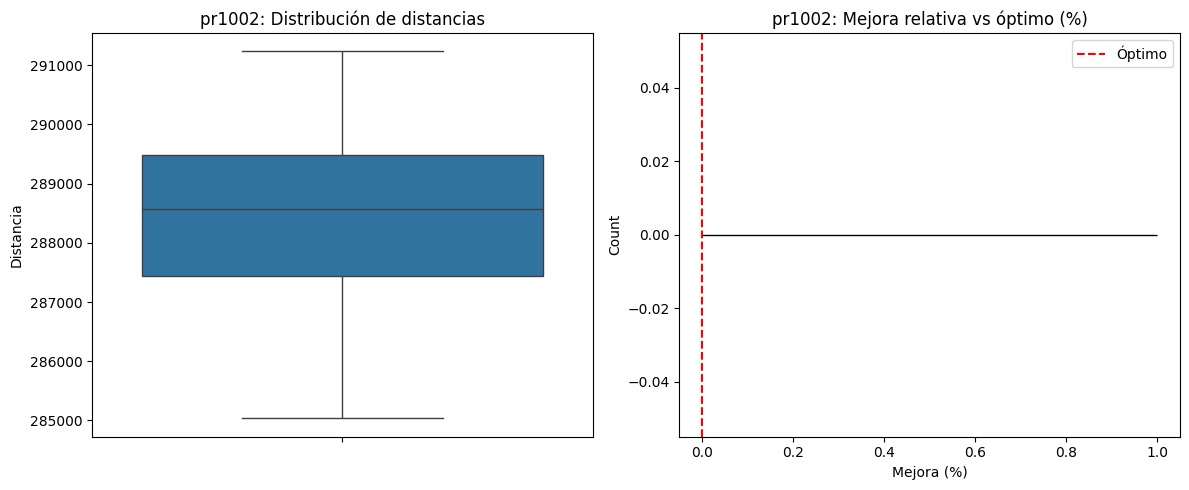

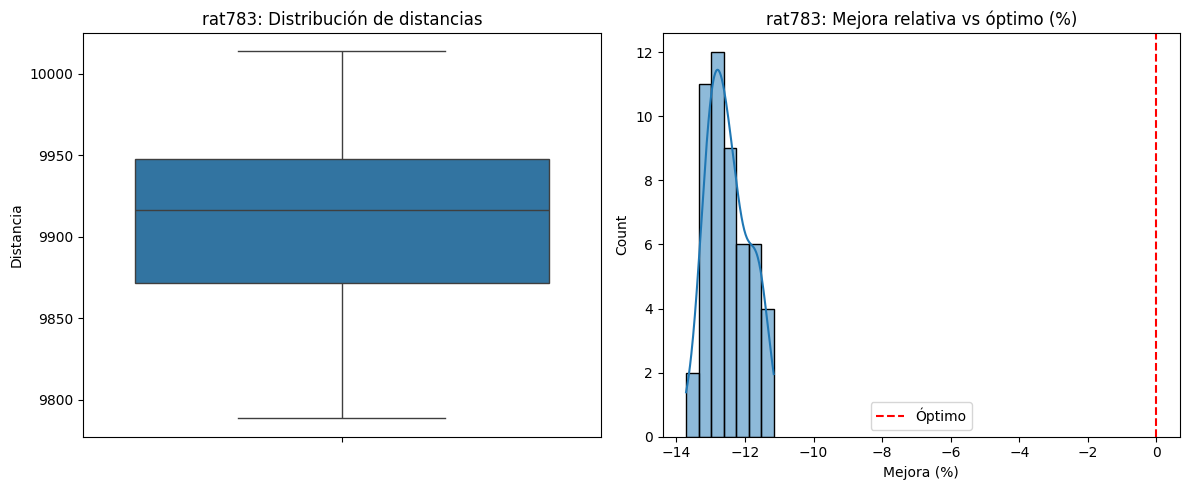

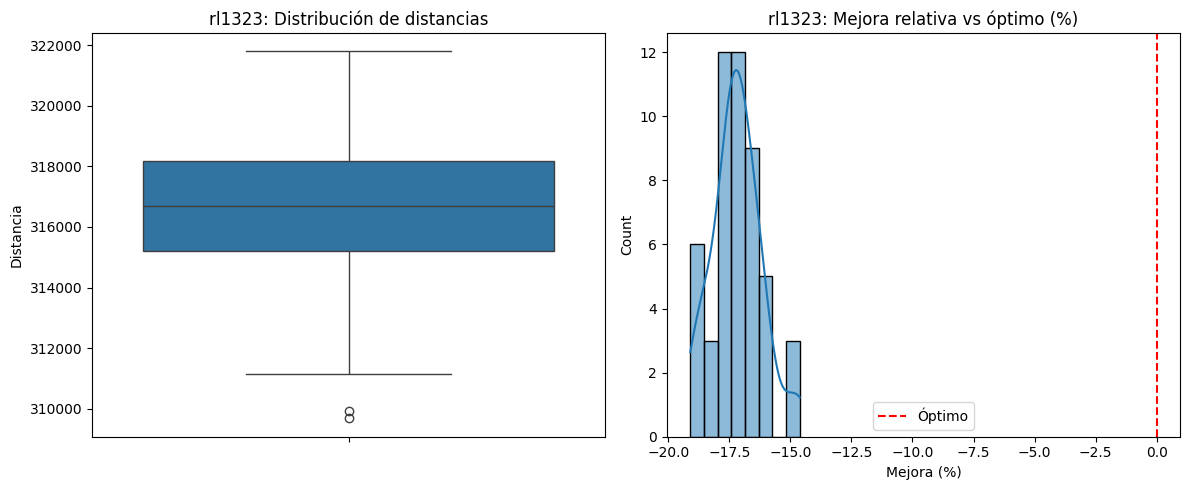

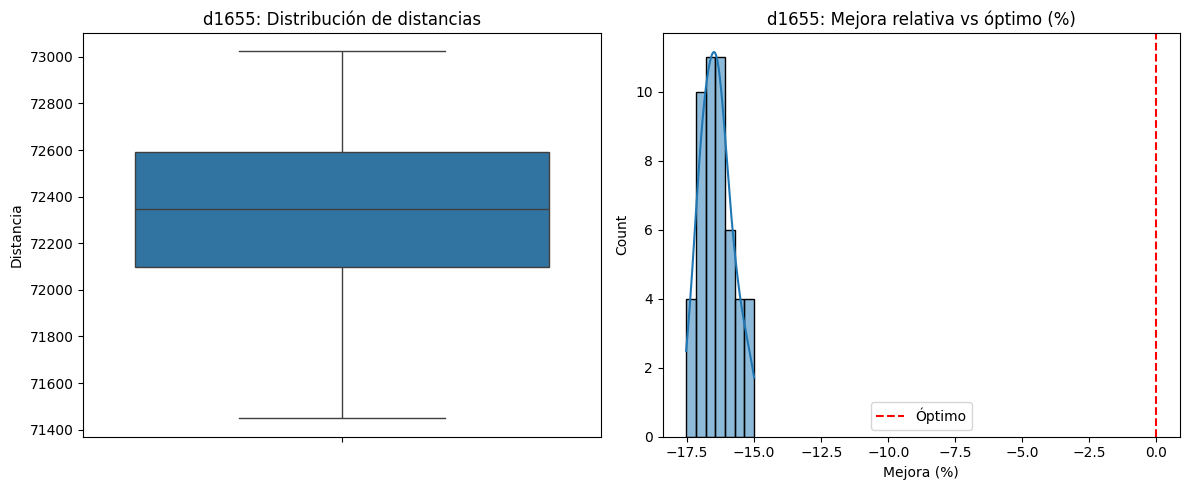

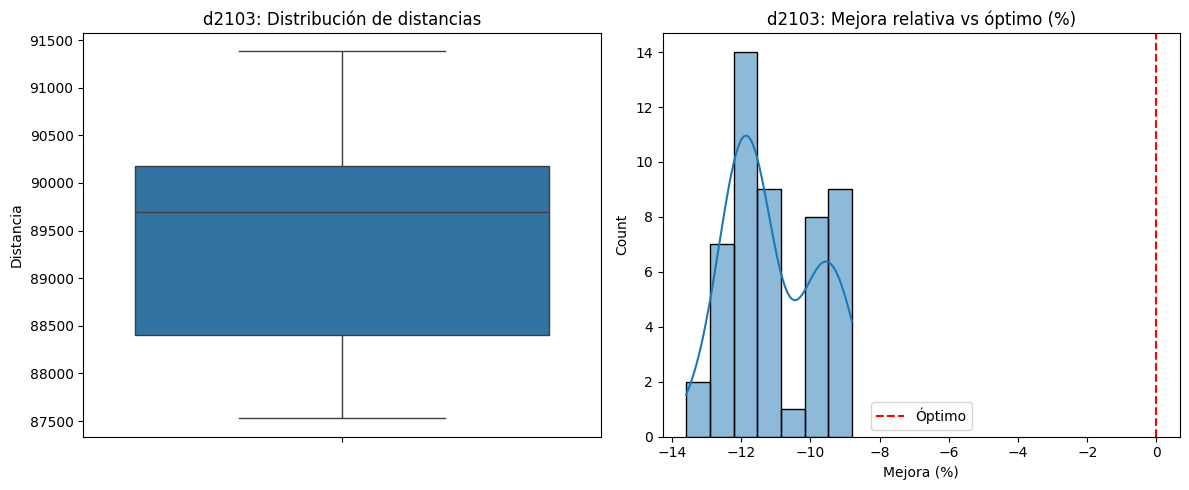

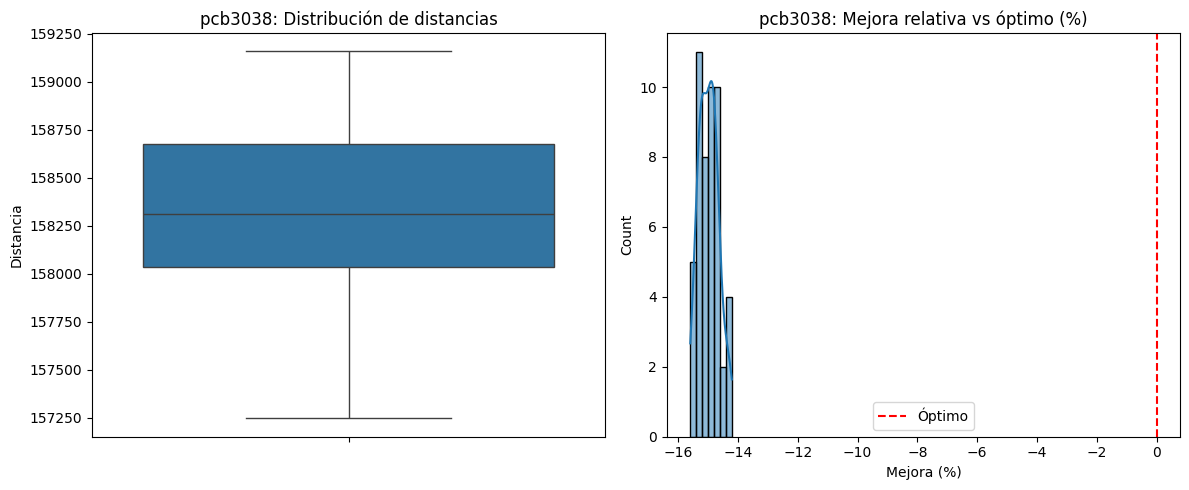

In [79]:
plot_results(all_dfs)